In [1]:
import numpy as np
import torch
from torch import nn
from torch import functional as F
from torchviz import make_dot, make_dot_from_trace
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/cortax/Anaconda3/Library/bin/graphviz/'
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from livelossplot import PlotLosses

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [4]:
sigma_noise = 0.1
(x_data, y_data) = torch.load('foong_data.pt')

In [5]:
x_data = x_data.to(device)
y_data = y_data.to(device)

In [6]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [7]:
def rho_to_sigma(rho):
    sigma = torch.log(1 + torch.exp(rho))
    return sigma

In [8]:
def sigma_to_rho(sigma):
    rho = torch.log(torch.exp(sigma) - 1)
    return rho

In [9]:
class ProbabilisticLinear(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(ProbabilisticLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.q_weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.q_weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.q_bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.q_bias_rho = nn.Parameter(torch.Tensor(out_features))
        
        self.weight_epsilon = torch.Tensor(out_features, in_features)
        self.bias_epsilon = torch.Tensor(out_features, in_features)
        
        self.weight_sample = torch.Tensor(out_features, in_features)
        self.bias_sample = torch.Tensor(out_features, in_features)
        
        self.reset_parameters()
        
        mu = torch.tensor(0.0)
        rho = sigma_to_rho(torch.tensor(1.0))
        
        self.prior_weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.prior_weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.prior_bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.prior_bias_rho = nn.Parameter(torch.Tensor(out_features))
        
        self.prior_weight_mu.requires_grad = False
        self.prior_weight_rho.requires_grad = False
        self.prior_bias_mu.requires_grad = False
        self.prior_bias_rho.requires_grad = False
        
        nn.init.constant_(self.prior_weight_mu, mu)
        nn.init.constant_(self.prior_weight_rho, rho)
        nn.init.constant_(self.prior_bias_mu, mu)
        nn.init.constant_(self.prior_bias_rho, rho)
        
    def generate_rand(self):
        self.weight_epsilon = torch.randn(size=self.q_weight_mu.size()).to(device)
        self.bias_epsilon = torch.randn(size=self.q_bias_mu.size()).to(device)
        return (self.weight_epsilon, self.bias_epsilon)
    
    def reparameterization(self):
        sigma_weight = rho_to_sigma(self.q_weight_rho)
        sigma_bias = rho_to_sigma(self.q_bias_rho)
        
        self.weight_sample = self.weight_epsilon.mul(sigma_weight).add(self.q_weight_mu)
        sigma_bias = rho_to_sigma(self.q_bias_rho)
        self.bias_sample = self.bias_epsilon.mul(sigma_bias).add(self.q_bias_mu)
        return (self.weight_sample, self.bias_sample)

    def q_log_pdf(self):
        sigma_weight = rho_to_sigma(self.q_weight_rho)
        nw = torch.distributions.Normal(self.q_weight_mu, sigma_weight)
        
        sigma_bias = rho_to_sigma(self.q_bias_rho)
        nb = torch.distributions.Normal(self.q_bias_mu, sigma_bias)
        
        return nw.log_prob(self.weight_sample).sum() + nb.log_prob(self.bias_sample).sum()
    
    def prior_log_pdf(self):
        sigma_weight = rho_to_sigma(self.prior_weight_rho)
        nw = torch.distributions.Normal(self.prior_weight_mu, sigma_weight)
        
        sigma_bias = rho_to_sigma(self.prior_bias_rho)
        nb = torch.distributions.Normal(self.prior_bias_mu, sigma_bias)
        
        return nw.log_prob(self.weight_sample).sum() + nb.log_prob(self.bias_sample).sum()
    
    def reset_parameters(self):
        torch.nn.init.normal_(self.q_weight_mu, mean=0.0, std=5.0)
        torch.nn.init.constant_(self.q_weight_rho, -1.0)
        torch.nn.init.normal_(self.q_bias_mu, mean=0.0, std=5.0)
        torch.nn.init.constant_(self.q_bias_rho, -1.0)
       
    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight_sample, bias=self.bias_sample)

In [10]:
class RegressionModel(nn.Module):
    def __init__(self, H):
        super(RegressionModel, self).__init__()
        
        self.linear1 = ProbabilisticLinear(1, H)
        self.linear2 = ProbabilisticLinear(H,1)
        
        self.registered_layers = []
        self.registered_layers.append(self.linear1)
        self.registered_layers.append(self.linear2)
        
        self.nb_parameters = self.count_parameters()
        
        self.to(device)
        
    def forward(self, x):
        out = x;
        for k in range(len(self.registered_layers)-1):
            out = torch.tanh(self.registered_layers[k](out))
        out = self.registered_layers[-1](out)
        return out
    
    def resample_parameters(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].generate_rand()
            self.registered_layers[k].reparameterization()
        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
        
    def compute_elbo(self, x_data, y_data):
        S = 1
        L = 0 
        for i in range(0,S):
            self.resample_parameters()

            LQ = self.linear1.q_log_pdf() 
            LP = self.linear1.prior_log_pdf() 

            y_pred = self.forward(x_data)

            LL = log_norm(y_data, y_pred.t(), torch.tensor(sigma_noise).to(device)).sum()
        
            #Reparametrization trick:
            L = L + LQ - LP - LL

        return L/S

In [11]:
model = RegressionModel(50)

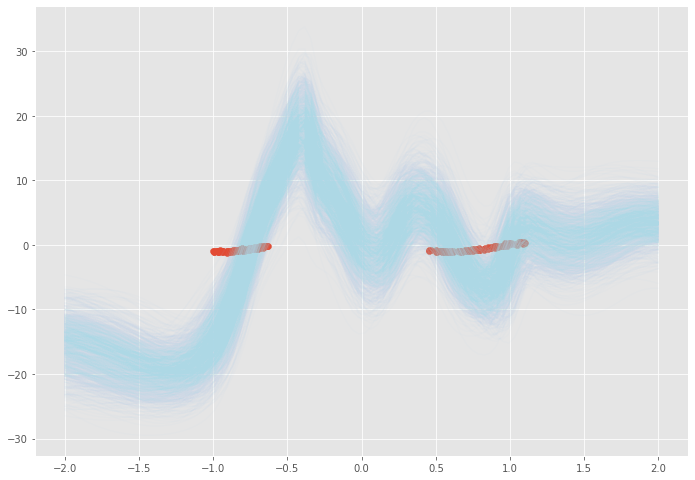

In [12]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(x_data.cpu(), y_data.cpu())
#plt.axis([-2, 2, -2, 2])
for _ in range(1000):
    model.resample_parameters()

    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [13]:
#make_dot(model(x_data), params=dict(model.named_parameters()))

In [13]:
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5,verbose=True)
optimizer.zero_grad()

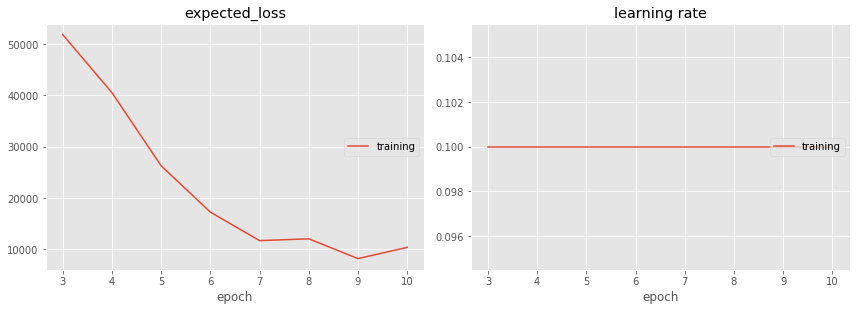

expected_loss:
training   (min: 8205.325, max: 266306.406, cur: 10390.591)

learning rate:
training   (min:    0.100, max:    0.100, cur:    0.100)


In [14]:
%matplotlib inline
num_epoch = 10
num_iterations = 50
liveloss = PlotLosses()

for j in range(num_epoch):
    logs = {}
    losses = [None] * num_iterations
    
    for k in range(num_iterations):
        optimizer.zero_grad()
        loss = model.compute_elbo(x_data, y_data)
        losses[k] = loss
        loss.backward()
        optimizer.step()
    
    logs['expected_loss'] = torch.stack(losses).mean().detach().clone().cpu().numpy()
    logs['learning rate'] = optimizer.param_groups[0]['lr']
    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(logs['expected_loss'])

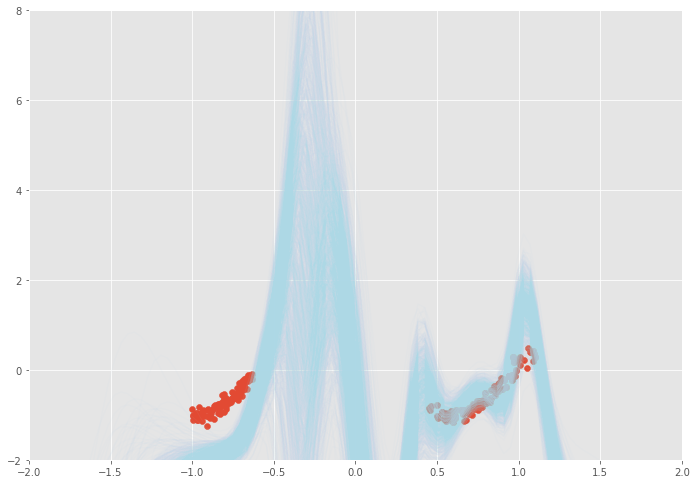

In [15]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(x_data.cpu(), y_data.cpu())
plt.axis([-2, 2, -2, 8])

for _ in range(1000):
    (L1_weight_epsilon, L1_bias_epsilon) = model.linear1.generate_rand()
    (L1_weight_sample, L1_bias_sample) = model.linear1.reparameterization()
    
    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')
plt.savefig('Plot_BBVI.png')